This Jupyter notebook does the following:

1. makes a TSNE based on the data of all monomers for which we have TDDFT, coupling site and substructure data
2. performs a furthest point sampling (FPS) on that TSNE to find the 1000 (~1%) most unique monomers
3. generates all combinations of monomer pairs from these 1000 monomers
4. run a minibatch k-means clustering on all the resulting 499500 monomer pairs 
5. perform an even sampling on the resulting clusters to select the most diverse monomer pairs for which dimers will be generated
6. Generate list coupling products from monomer pairs for submission to the crosscoupler tool.

In [1]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn.model_selection import StratifiedKFold

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter

import itertools as it

import random
import ast

# 1. Build TSNE

In [30]:
# load data from https://archive.materialscloud.org/record/2022.162

df = pd.read_csv("Data_FORMED.csv", sep=",")

In [31]:
# prune dataframe to remove irrelevant columns

df.drop(labels="name", inplace=True, axis=1)
df.drop(labels="gap", inplace=True, axis=1)
df.drop(labels="NO_FG_DETECTED", inplace=True, axis=1)
df.drop(labels="Filename", inplace=True, axis=1)
df.dropna(inplace=True)
print(f"Shape of df after dropping all irrelevant columns: {df.shape}")

Shape of df after dropping all irrelevant stuff: (1001, 184)


In [32]:
# transform dataframe into matrix

dfm = df.to_numpy(dtype=float)

print(f"Shape of dfm after dropping all the redundant stuff: {dfm.shape}")
np.save("X.npy", dfm)

Shape of dfm after dropping all the redundant stuff: (1001, 184)


In [33]:
# run the TSNE (very slow if run locally)

dfm = np.load("X.npy")

Y = TSNE(
    n_components=2,
    init="pca",
    perplexity=100,
    early_exaggeration=12.0,
    learning_rate=200.0,
    n_iter=1000,
    metric="cosine",
    random_state=42,
).fit_transform(dfm)

# save TSNE after running it

np.save("Y.npy", Y)

/home/terry/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(
/home/terry/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


In [34]:
# load the TSNE (if run elsewhere)

Y = np.load('Y.npy')

In [35]:
print(df.columns)

Index(['S1_exc', 'S2_exc', 'S3_exc', 'S4_exc', 'S5_exc', 'T1_exc', 'T2_exc',
       'T3_exc', 'T4_exc', 'T5_exc',
       ...
       'chloride', 'bromide', 'boron_halide_(B-X)', 'carbon_halide_(C-X)',
       'nitrogen_halide_(N-X)', 'oxygen_halide_(O-X)', 'silyl_halide_(Si-X)',
       'phosphorus_halide_(P-X)', 'sulfur_halide_(S-X)',
       'selenium_halide_(Se-X)'],
      dtype='object', length=184)


In [37]:
# find the column index for the property in question

print(df.columns.get_loc('HOMO'))

10


In [39]:
# find the column name for a given index

print(df.columns[10])

HOMO


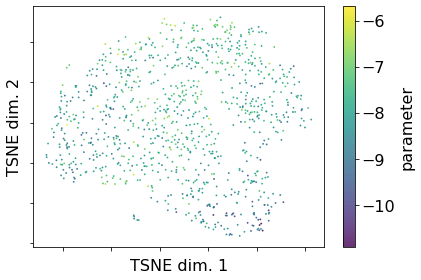

In [40]:
# plot the TSNE in which points are coloured according to those certain column values
# to see if the TSNE is not too segregated according to those properties
# especially properties with very large ranges of values (SCF energy, number of alkyl chains, etc.)

x = Y[:, 0]
y = Y[:, 1]
z = dfm[:, 10].flatten()  # property by which to colour the TSNE

fig, ax = plt.subplots()

cax = ax.scatter(
    x, y, c=z, vmin=z.min(), vmax=z.max(), s=0.75, cmap="viridis", alpha=0.8
)
cbar = fig.colorbar(cax)
cbar.set_label(r"parameter", fontsize=16)
cbar.ax.tick_params(labelsize=16)

ax.set_xlabel(r"TSNE dim. 1", fontsize=16)
ax.set_ylabel(r"TSNE dim. 2", fontsize=16)

ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())

fig.tight_layout()
plt.show()

# 2. Furthest point sampling of most unique monomers

In [41]:
# broadcast p0 into an array and compute the euclidean distance between it and all other points

def calc_distances(p0, points):
    return ((p0 - points)**2).sum(axis=1)

In [42]:
# function to do the FPS
# pts is the collection of all points, from which K number of most dissimlar points will be sampled

def incremental_fps(pts, K):
    farthest_pts = np.zeros((K, 2)) # where the two values representing the sampled points will be stored
    idxs_pts = np.zeros((K, 1), dtype=int) # where the indices of the sampled points will be stored
    first_idx = np.random.randint(len(pts)) # the first point is chosen randomly, and the data is saved 
    farthest_pts[0] = pts[first_idx]
    idxs_pts[0] = first_idx
    
    # calculate euclidean distance between this point and all others using the function above
    
    distances = calc_distances(farthest_pts[0], pts) 
    for i in range(1, K):
        idx = np.argmax(distances) # find index of the point that is furthest from the previous point
        idxs_pts[i] = idx # save that index
        farthest_pts[i] = pts[idx] # save that point's data
        
        # pair-wise minima between the distances which have already been computed with respect to the first point
        # and the distance between the current point and all others
        
        distances = np.minimum(distances, calc_distances(farthest_pts[i], pts))
        
    return farthest_pts, idxs_pts

In [43]:
# select n_points from the set

n_points = 1000

# get data and indices of the points obtained by FPS using the function defined above

solution_set, idxs_pts = incremental_fps(Y, n_points)

In [44]:
# check that the arrays of the subset of the original dataset based on the FPS indices
# and the selected data are element-wise equal
# allclose: Returns True if two arrays are element-wise equal within a tolerance

assert np.allclose(Y[idxs_pts].reshape(n_points,2)[:],solution_set[:])

dfm[idxs_pts,:]

array([[[ 5.1376,  5.5855,  5.659 , ...,  0.    ,  0.    ,  0.    ]],

       [[ 7.4561,  9.7588, 10.2425, ...,  0.    ,  0.    ,  0.    ]],

       [[ 6.6189,  7.1412,  8.1084, ...,  0.    ,  0.    ,  0.    ]],

       ...,

       [[ 4.4999,  5.1236,  5.4453, ...,  0.    ,  0.    ,  0.    ]],

       [[ 5.3653,  6.2298,  6.7285, ...,  0.    ,  0.    ,  0.    ]],

       [[ 5.1147,  5.6024,  6.4997, ...,  0.    ,  0.    ,  0.    ]]])

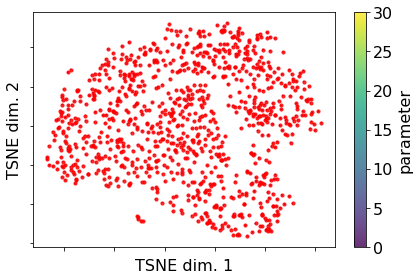

In [45]:
# plot the points which have been sampled by FPS overlayed on the TSNE

x = Y[:, 0]
y = Y[:, 1]
z = dfm[:,98].flatten()

fig, ax = plt.subplots()

# all TSNE data from above
cax = ax.scatter(x, y, c=z, vmin=z.min(), vmax=z.max(), s=0.75, cmap='viridis', alpha=0.8)

# points selected by FPS
cax2 = ax.scatter(solution_set[:,0], solution_set[:,1], c='red', s=10, alpha=0.8)

cbar = fig.colorbar(cax)
cbar.set_label(r'parameter', fontsize=16)
cbar.ax.tick_params(labelsize=16)

ax.set_xlabel(r'TSNE dim. 1', fontsize=16) 
ax.set_ylabel(r'TSNE dim. 2', fontsize=16) 

ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())

fig.tight_layout()
plt.show()

# 3. Generate all monomer pair combinations

In [46]:
monomer_cpl_idxs = []
monomer_cpl_feats = []

# use itertools to make all combinations of 1000 selected monomers 

for i,j in it.combinations(idxs_pts, 2):
    
    # pairs of monomer indices, to keep track of where the elements of the monomer pairs come from
    
    monomer_cpl_idxs.append((i[0],j[0])) 
    
    # fuse the TSNE features of the monomer pairs to make a new array (stack them horizontally)
    
    monomer_cpl_feat = np.hstack((dfm[i[0],:],dfm[j[0],:]))
#     print(dfm[i[0],:],dfm[j[0],:])
    
    # put all the pairwise features together
    
    monomer_cpl_feats.append(monomer_cpl_feat)


In [47]:
# check that there are as many sets of pairwsie TSNE features as monomer pairs

assert len(monomer_cpl_idxs)==len(monomer_cpl_feats)

In [48]:
print(monomer_cpl_idxs[:100])

[(308, 725), (308, 550), (308, 80), (308, 113), (308, 108), (308, 851), (308, 350), (308, 542), (308, 877), (308, 469), (308, 947), (308, 543), (308, 186), (308, 372), (308, 28), (308, 358), (308, 265), (308, 813), (308, 482), (308, 95), (308, 496), (308, 954), (308, 821), (308, 852), (308, 82), (308, 207), (308, 435), (308, 217), (308, 719), (308, 391), (308, 70), (308, 339), (308, 780), (308, 910), (308, 50), (308, 181), (308, 38), (308, 857), (308, 854), (308, 204), (308, 26), (308, 479), (308, 908), (308, 566), (308, 429), (308, 838), (308, 411), (308, 562), (308, 122), (308, 434), (308, 386), (308, 168), (308, 609), (308, 839), (308, 804), (308, 123), (308, 862), (308, 601), (308, 461), (308, 734), (308, 1), (308, 179), (308, 929), (308, 534), (308, 302), (308, 907), (308, 732), (308, 967), (308, 111), (308, 751), (308, 410), (308, 697), (308, 769), (308, 324), (308, 985), (308, 647), (308, 141), (308, 387), (308, 682), (308, 919), (308, 891), (308, 975), (308, 537), (308, 362), (

In [49]:
print(monomer_cpl_feats[:100])

[array([ 5.137600e+00,  5.585500e+00,  5.659000e+00,  5.717100e+00,
        5.970600e+00,  3.942600e+00,  4.281500e+00,  4.309100e+00,
        4.736300e+00,  4.924000e+00, -8.497840e+00,  7.733400e-01,
        2.637000e+00,  2.440000e+00,  2.502000e+00,  3.229000e+00,
        3.613000e+00,  2.340000e+00,  1.984000e+00,  1.898000e+00,
        2.470000e+00,  2.240000e+00,  6.000000e-03,  2.000000e-02,
        8.600000e-02,  4.040000e-01,  8.300000e-02,  4.400000e+01,
        0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
        0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
        0.000000e+00,  0.000000e+00,  0.000000e+00,  4.000000e+00,
        1.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
        0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
        0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
        0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
        0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000

In [50]:
# turn the pairwise features into an array for generating the second TSNE

X2 = np.array(monomer_cpl_feats)

In [51]:
# save new imput of fused monomer pairs

np.save('X2.npy', X2)

# 4. Minibatch k-means clustering of all monomer pairs

In [52]:
# define instance of MiniBatchKMeans class, which clusters the points in a given number of clusters, each with a
# certain distance from the centroid of the cluster

kmeans = MiniBatchKMeans(n_clusters=100,
                         random_state=42, 
                         batch_size=6,
                         max_iter=10)

# fit on representation of the whole data to assign each point to a cluster

Y2 = kmeans.fit_transform(X2)

In [53]:
Y2.shape

(499500, 100)

In [54]:
# index of the cluster to which each compound has been attributed

Y2_labels = kmeans.labels_

# high-dimensional coordinate of the centroid of each cluster (can't be plotted as is)

Y2_centroids = kmeans.cluster_centers_

Y2_centroids

array([[4.37606929e+00, 4.80439428e+00, 5.11037871e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.49278480e+00, 4.91725376e+00, 5.26487783e+00, ...,
        1.80995475e-03, 0.00000000e+00, 0.00000000e+00],
       [4.95436778e+00, 6.23109666e+00, 6.80779726e+00, ...,
        0.00000000e+00, 3.03951368e-03, 0.00000000e+00],
       ...,
       [6.25989931e+00, 7.09431697e+00, 7.47621904e+00, ...,
        0.00000000e+00, 4.58715596e-03, 2.29357798e-03],
       [4.28853374e+00, 4.88185890e+00, 5.25262209e+00, ...,
        7.69230769e-03, 0.00000000e+00, 0.00000000e+00],
       [4.63212040e+00, 5.15275130e+00, 5.55629469e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [55]:
# the set of labels
uniq_levels = np.unique(Y2_labels)

# dictionary list comprehension to count the number of instances of each label; puts that in a dictionary

uniq_counts = {level: sum(Y2_labels == level) for level in uniq_levels}

# i.e. how many points are in each cluster

print(uniq_counts)

{0: 10504, 1: 6206, 2: 2168, 3: 10958, 4: 4874, 5: 1861, 6: 1879, 7: 3701, 8: 5741, 9: 4949, 10: 1621, 11: 6065, 12: 7366, 13: 8156, 14: 6761, 15: 2227, 16: 4223, 17: 4655, 18: 2518, 19: 6000, 20: 9659, 21: 6600, 22: 2745, 23: 4525, 24: 2726, 25: 3968, 26: 3539, 27: 4242, 28: 10360, 29: 3384, 30: 8803, 31: 4625, 32: 7180, 33: 4680, 34: 6397, 35: 2203, 36: 4432, 37: 9136, 38: 6885, 39: 2885, 40: 6329, 41: 1475, 42: 2695, 43: 4518, 44: 3778, 45: 6767, 46: 5288, 47: 4184, 48: 1895, 49: 6066, 50: 8869, 51: 3098, 52: 761, 53: 4440, 54: 1880, 55: 5040, 56: 5242, 57: 5304, 58: 5807, 59: 4341, 60: 2631, 61: 9254, 62: 4241, 63: 6049, 64: 3615, 65: 2703, 66: 7737, 67: 9638, 68: 994, 69: 6002, 70: 4130, 71: 11579, 72: 7353, 73: 9315, 74: 3782, 75: 977, 76: 4044, 77: 5147, 78: 2280, 79: 3715, 80: 5453, 81: 6434, 82: 1347, 83: 6021, 84: 7883, 85: 6916, 86: 1537, 87: 4356, 88: 6758, 89: 2407, 90: 5582, 91: 4832, 92: 5178, 93: 2980, 94: 5710, 95: 3599, 96: 4462, 97: 2799, 98: 5368, 99: 5508}


# 5. Even sampling of clusters

In [56]:
# a function that samples an equal number of points from each cluster (regardless of the size of the cluster)
# so that more 'unique' (smaller) clusters are sampled more highly compared to clusters of more generic molecules
# from https://stackoverflow.com/questions/48425201/sample-x-examples-from-each-class-label

from collections import Counter

def balanced_sample_maker(X, y, sample_size, random_seed=42):
    uniq_levels = np.unique(y) # the set of labels (i.e. 0-99)
    
    uniq_counts = {level: sum(y == level) for level in uniq_levels} 

    if not random_seed is None:
        np.random.seed(random_seed)

    # find observation index of each class level
    
    groupby_levels = {}
    for ii, level in enumerate(uniq_levels):
        obs_idx = [idx for idx, val in enumerate(y) if val == level]
        groupby_levels[level] = obs_idx
        
    # oversampling on observations of each label
    
    balanced_copy_idx = []
    for gb_level, gb_idx in groupby_levels.items():
        over_sample_idx = np.random.choice(gb_idx, size=sample_size, replace=True).tolist()
        balanced_copy_idx+=over_sample_idx
    np.random.shuffle(balanced_copy_idx)

    data_train=X[balanced_copy_idx]
    labels_train=y[balanced_copy_idx]
    if  ((len(data_train)) == (sample_size*len(uniq_levels))):
        print('number of sampled example ', sample_size*len(uniq_levels), 'number of sample per class ', sample_size, ' #classes: ', len(list(set(uniq_levels))))
    else:
        print('number of samples is wrong ')

    labels, values = zip(*Counter(labels_train).items())
    print('number of classes ', len(list(set(labels_train))))
    check = all(x == values[0] for x in values)
    print(check)
    if check == True:
        print('All classes have the same number of examples')
    else:
        print('Repeat again your sampling your classes are not balanced')
        
    # histogram of the number of points sampled from each cluster
    
    indexes = np.arange(len(labels))
    width = 0.5
    plt.bar(indexes, values, width)
    plt.xticks(indexes + width * 0.5, labels)
    plt.show()
    
    indices_train = balanced_copy_idx
    return data_train,labels_train,indices_train


number of sampled example  1000 number of sample per class  10  #classes:  100
number of classes  100
True
Good all classes have the same number of examples


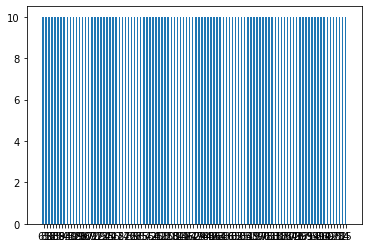

In [57]:
X_train,y_train, indices_train = balanced_sample_maker(X2,Y2_labels,10)

In [58]:
X_train.shape

(1000, 368)

In [59]:
# the set of labels

uniq_levels = np.unique(y_train)

# dictionary to show how many selected points are from each cluster (should each be 10)

uniq_counts = {level: sum(y_train == level) for level in uniq_levels}
print(uniq_counts)

{0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10, 10: 10, 11: 10, 12: 10, 13: 10, 14: 10, 15: 10, 16: 10, 17: 10, 18: 10, 19: 10, 20: 10, 21: 10, 22: 10, 23: 10, 24: 10, 25: 10, 26: 10, 27: 10, 28: 10, 29: 10, 30: 10, 31: 10, 32: 10, 33: 10, 34: 10, 35: 10, 36: 10, 37: 10, 38: 10, 39: 10, 40: 10, 41: 10, 42: 10, 43: 10, 44: 10, 45: 10, 46: 10, 47: 10, 48: 10, 49: 10, 50: 10, 51: 10, 52: 10, 53: 10, 54: 10, 55: 10, 56: 10, 57: 10, 58: 10, 59: 10, 60: 10, 61: 10, 62: 10, 63: 10, 64: 10, 65: 10, 66: 10, 67: 10, 68: 10, 69: 10, 70: 10, 71: 10, 72: 10, 73: 10, 74: 10, 75: 10, 76: 10, 77: 10, 78: 10, 79: 10, 80: 10, 81: 10, 82: 10, 83: 10, 84: 10, 85: 10, 86: 10, 87: 10, 88: 10, 89: 10, 90: 10, 91: 10, 92: 10, 93: 10, 94: 10, 95: 10, 96: 10, 97: 10, 98: 10, 99: 10}


# 6. Generate coupling products

The final step requires the generation of coupling site information in the format provided by the crosscoupler.

In [95]:
# load the data containing the compound names and coupling site information

df_all = pd.read_csv("[coupling_site_data].csv", sep=" ", index_col=0)
df_all.head(1)

,name,S1_exc,S2_exc,S3_exc,S4_exc,S5_exc,T1_exc,T2_exc,T3_exc,T4_exc,...,oxygen_halide_(O-X),silyl_halide_(Si-X),phosphorus_halide_(P-X),sulfur_halide_(S-X),selenium_halide_(Se-X),NO_FG_DETECTED,atoms,coord,coupling_sites,nonequiv_sites
0,CONFAM,4.4809,6.298,7.6115,7.8118,8.0693,4.1821,4.2175,6.3567,6.857,...,0.0,0.0,0.0,0.0,0.0,0.0,"['S', 'C', 'C', 'O', 'N', 'H', 'H', 'H', 'H', ...",[[-0.85972967 1.73011864 7.70605601]\n [-1.4...,[],[]


In [225]:
# take the FPS-sampled monomer pairs, and select a random number of cross-coupling products

fragments = []
count = 0
for index in indices_train:

    # monomer_cpl_idxs is a list of tuples, which are the indices of the monomers to be coupled together

    monoind_1 = monomer_cpl_idxs[index][
        0
    ]  # retrieve structure entries in dataset based on their indices
    monoind_2 = monomer_cpl_idxs[index][
        1
    ]  # for each monomer in the selected monomer pair

    # ast.literal_eval converts str of a python object (e.g. a list) into that object
    # gather all unique coupling sites

    sites1 = ast.literal_eval(df_all.iloc[monoind_1]["nonequiv_sites"])
    sites2 = ast.literal_eval(df_all.iloc[monoind_2]["nonequiv_sites"])

    # gather list of atoms

    atoms1 = ast.literal_eval(df_all.iloc[monoind_1]["atoms"])
    atoms2 = ast.literal_eval(df_all.iloc[monoind_2]["atoms"])

    # count number of heavy (non-hydrogen) atoms

    nheavy1 = len([atom for atom in atoms1 if atom != "H"])
    nheavy2 = len([atom for atom in atoms2 if atom != "H"])

    # check if the list is not empty and if the eventual coupling product is small enough

    if sites1 and sites2 and (nheavy1 + nheavy2 <= 45):

        # names of the structures, based on their index in the original list of monomers

        name1 = str(df_all.iloc[monoind_1]["name"])
        name2 = str(df_all.iloc[monoind_2]["name"])

        all_sites = []
        sites_to_use = []

        # use itertools to gather all products of elements from two lists; make a list from that

        all_sites = list(it.product(sites1, sites2))
        indices_of_all_sites = [i for i, _ in enumerate(all_sites)]

        # pick a random number of combinations from all possible coupling site combinations for these two monomers
        # replace=False -> once a selection has been made, it is removed from the list ()
        # the choice can't be made on an itertools object, so it is done on the list of indices

        indices_of_sites_to_use = np.random.choice(
            indices_of_all_sites, size=random.randint(1, len(all_sites)), replace=False
        )

        # place the selected coupling site pairs in a list, based on their indices

        for index in indices_of_sites_to_use:
            sites_to_use.append(all_sites[index])

        # collect the names of the two molecules to couple and the coupling site(s) that have been chosen in one place
        # count how many dimers will be generated

        for pair_site in sites_to_use:
            fragments.append([name1, pair_site[0], name2, pair_site[1]])
            count += 1

In [ ]:
count

In [240]:
# Save the 2D array in a text file

file = open("fragments.txt", "w+")
content = str(fragments)
file.write(content)
file.close()

In [ ]:
# display the contents of the text file, each line of which can be fed to the crosscoupler for 3D dimer generation

file = open("fragments.txt", "r")
content = file.read()
file.close()

# convert string of list to list

content = ast.literal_eval(content) 

In [ ]:
for index in indices_train:
    print(monomer_cpl_idxs[index])